In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources\hawaii.sqlite")


In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
#print(session)


# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results - OK

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [12]:
# PREVIEW - INSPECT THE INFORMATION IN EACH TABLE
from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()

# Use Inspector to print the column names and types of measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

print("-"*12)
print(engine.execute('SELECT * FROM measurement LIMIT 2').fetchall())

print("-"*12)
# Use Inspector to print the column names and types of station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

print("-"*12)
engine.execute('SELECT * FROM station LIMIT 2').fetchall()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------
[(1, 'USC00519397', '2010-01-01', 0.08, 65.0), (2, 'USC00519397', '2010-01-02', 0.0, 63.0)]
------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
------------


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)]

In [127]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# 1. GET THE LAST DATE REGISTER IN THE DB  
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
lastdate
#type(lastdate)


str

In [35]:
# 2. DATE IS SAVED AS A STRING. NEED TO BE CHANGED TO DATE FORMAT
lastdateD = dt.datetime.strptime(lastdate,'%Y-%m-%d')
print(lastdateD)
lastdateD


2017-08-23 00:00:00


datetime.datetime

In [99]:
## Calculate the date 1 year ago from the last data point in the database
# Find date from last 12 months from LastDate
last12monthsS = lastdateD - dt.timedelta(days=366)
print(last12monthsS)
last12monthsS

2016-08-22 00:00:00


datetime.datetime(2016, 8, 22, 0, 0)

In [100]:
# Perform a query to retrieve the data and precipitation scores
#Design a query to retrieve the last 12 months of precipitation data 
precipLast12Months = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= last12monthsS).all()

# the results is a list of tuples of (date,precip). 

In [101]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precipitationDF = pd.DataFrame(precipLast12Months, columns = ["date","prcp"])
precipitationDF = precipitationDF.dropna()
precipitationDF.set_index("date", inplace=True,)
precipitationDF.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [102]:
# Sort the dataframe by date
precipitationDF.sort_index(0,ascending=False)


,prcp
date,
2017-08-23,0.45
2017-08-23,0.08
2017-08-23,0.00
2017-08-23,0.00
2017-08-22,0.00
...,...
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02


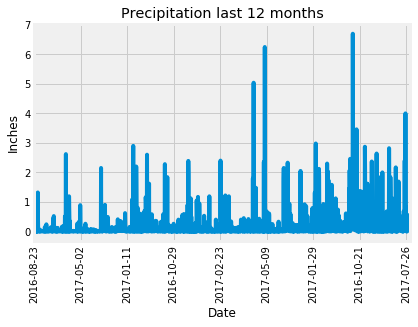

In [103]:
precipitationDF["prcp"].plot(title="Precipitation last 12 months", rot=90)
plt.ylabel("Inches")
plt.xlabel("Date")
plt.show()

In [104]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitationDF["prcp"].describe()


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [105]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()


[(9)]

In [106]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.prcp)).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

[('USC00513117', 2696),
 ('USC00518838', 342),
 ('USC00519523', 2572),
 ('USC00519281', 2772),
 ('USC00516128', 2484),
 ('USC00519397', 2685),
 ('USC00511918', 1932),
 ('USC00514830', 1937),
 ('USC00517948', 683)]

In [107]:
#The station with the highest number of observations
MostActiveStation = session.query(Measurement.station).group_by(Measurement.station).order_by(Measurement.prcp.desc()).first()


In [108]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
MostActiveStationId = MostActiveStation[0]

minPrcp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == MostActiveStationId).all()
maxPrcp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == MostActiveStationId).all()
avgPrcp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == MostActiveStationId).all()
#type(maxPrcp) #--> List, why?
print(f'The lowest temperature recorded for station {MostActiveStationId} was {minPrcp[0][0]}')
print(f'The highest temperature recorded for station {MostActiveStationId} was {maxPrcp[0][0]}')
print(f'The aveage temperature recorded for station {MostActiveStationId} was {avgPrcp[0][0]}')

The lowest temperature recorded for station USC00513117 was 59.0
The highest temperature recorded for station USC00513117 was 85.0
The aveage temperature recorded for station USC00513117 was 72.68918420081211


The station with the highest number of temperature observations is USC00519523


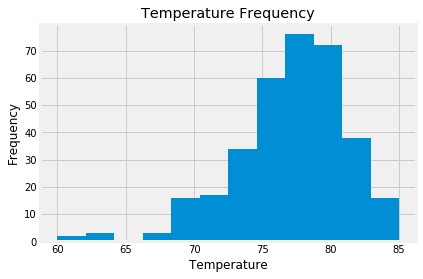

In [118]:
# Choose the station with the highest number of temperature observations.

MostActiveStationT = session.query(Measurement.station).group_by(Measurement.station).order_by(Measurement.tobs.desc()).first()
print(f'The station with the highest number of temperature observations is {MostActiveStationT[0]}')

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# 1. Query to retrieve the last 12 months of temperature observation. The results is a list of tuples of (date,tobs). 
TempLast12Months = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date >= last12monthsS).filter(Measurement.station == MostActiveStationT[0]).all()

# 2. Save the query results as a Pandas DataFrame and set the index to the date column
TempDF = pd.DataFrame(TempLast12Months, columns = ["date","tobs"])
TempDF = TempDF.dropna()
TempDF.set_index("date", inplace=True,)
TempDF.head()

# 3. Sort the dataframe by date
TempDF.sort_index(0,ascending=False)

# 4. Plot Histogram
plt.hist(TempDF["tobs"], bins = 12)
plt.title("Temperature Frequency")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()


## Bonus Challenge Assignment

In [119]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [120]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [121]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [122]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [123]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [124]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [125]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [126]:
# Plot the daily normals as an area plot with `stacked=False`
